In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from numpy.random import choice
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from matplotlib.colors import TwoSlopeNorm
from IPython.display import HTML
import os, csv
from requests import get
from io import StringIO
from shapely.geometry import Point
import random
import urllib.parse
import math
import datetime
import matplotlib.font_manager

In [2]:
data_path = 'data'
params = {'areaType': 'ltla', 'format': 'csv'}
cases_metric = 'newCasesBySpecimenDate'
deaths_metric = 'newDeaths28DaysByDeathDate'
metrics = [cases_metric, deaths_metric]
api_url = "https://api.coronavirus.data.gov.uk/v2/data"
case_days = 7
min_date = datetime.datetime(2020, 1, 1)
max_date = datetime.datetime(2021, 1, 29)
frames_per_day = 5
max_days = 1000
initial_message = ''
output_directory = 'out'
margins = [133000, 658000, 10600, 655000]
y_date = 600000
y_cases = 516000
y_deaths = 450000
x_text = 648000
date_size = 150
counter_size = 100
c_size = 5
plot_messages = True
plot_author = True
plot_legend = True

In [3]:
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

In [4]:
messages = [
    {'date': datetime.datetime(2020, 1, 30), 'message': 'First 2 cases in UK confirmed'},
    {'date': datetime.datetime(2020, 2, 29), 'message': 'First known case from community transmission'},
    {'date': datetime.datetime(2020, 3, 5), 'message': 'Change from "containment" to "delay" strategy'},
    {'date': datetime.datetime(2020, 3, 12), 'message': 'PHE stops contact tracing'},
    {'date': datetime.datetime(2020, 3, 23), 'message': 'Lockdown starts'},
    {'date': datetime.datetime(2020, 5, 10), 'message': 'Lockdown ends, COVID alert starts'},
    {'date': datetime.datetime(2020, 11, 5), 'message': 'Lockdown starts'},
    {'date': datetime.datetime(2020, 12, 2), 'message': 'Lockdown ends'},
    {'date': datetime.datetime(2020, 12, 28), 'message': 'Lockdown starts'},
]

# Get Ward Data

In [5]:
# Create local authority to ward lookup (https://geoportal.statistics.gov.uk/datasets/c721b6da8ea04f189baa27a1f3e32e06_0)
xref_sheet_filename = data_path + os.path.sep + "Output_Area_to_Ward_to_Local_Authority_District_(December_2019)_Lookup_in_England_and_Wales.csv"
xr = pd.read_csv(xref_sheet_filename)
xr.drop(xr.columns.difference(['LAD19CD','WD19CD']), 1, inplace=True)
xr.drop_duplicates(inplace=True)

In [6]:
# Get population of each ward (https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/wardlevelmidyearpopulationestimatesexperimental)
wd_pop = pd.read_csv(data_path + os.path.sep + "ward-population.csv")
wd_pop = wd_pop.rename(columns={'Ward Code 1': 'WD19CD'})
wd_pop.drop(wd_pop.columns.difference(['WD19CD','All Ages']), 1, inplace=True)
wd_pop['All Ages'] = pd.to_numeric(wd_pop['All Ages'], errors='coerce')

In [7]:
xr = pd.merge(xr, wd_pop, on=['WD19CD'], how='outer')
xr.dropna(axis = 0, how = 'all', inplace = True)

In [8]:
xr.head()

,WD19CD,LAD19CD,All Ages
0,E05008952,E06000001,8509.0
1,E05008949,E06000001,9978.0
2,E05008943,E06000001,8265.0
3,E05008944,E06000001,8450.0
4,E05009853,E06000002,5645.0


In [9]:
# Get https://geoportal.statistics.gov.uk/datasets/1d78d47c87df4212b79fe2323aae8e08_0
wd_filename = "zip://" + data_path + os.path.sep +  "Wards__December_2019__Boundaries_UK_BFC-shp.zip"
print("Loading ward map file from " + wd_filename)
wd = gpd.read_file(wd_filename)
wd = pd.merge(wd, xr, on=['WD19CD'], how='outer')

Loading ward map file from zip://data/Wards__December_2019__Boundaries_UK_BFC-shp.zip


In [10]:
wd.head()

,OBJECTID,WD19CD,WD19NM,WD19NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,geometry,LAD19CD,All Ages
0,1,E05000026,Abbey,None,544433,184379,0.081277,51.53983,1.256324e+06,8128.225572,"MULTIPOLYGON (((543581.800 184798.250, 543579....",E09000002,15770.0
1,2,E05000027,Alibon,None,549247,185196,0.150987,51.54592,1.364442e+06,6353.917640,"POLYGON ((549604.103 185773.202, 549613.098 18...",E09000002,10948.0
2,3,E05000028,Becontree,None,546863,185869,0.116912,51.55260,1.288082e+06,6341.645817,"POLYGON ((547563.400 186223.903, 547548.699 18...",E09000002,15261.0
3,4,E05000029,Chadwell Heath,None,548266,189340,0.138596,51.58342,3.384190e+06,9603.411571,"POLYGON ((548881.002 191087.601, 548877.300 19...",E09000002,11424.0
4,5,E05000030,Eastbrook,None,550774,186272,0.173453,51.55519,3.450577e+06,8987.802248,"POLYGON ((551552.897 187363.397, 551554.801 18...",E09000002,11584.0


# Get Local Authority Data

In [11]:
# https://geoportal.statistics.gov.uk/datasets/3a4fa2ce68f642e399b4de07643eeed3_0
ltla_filename = "zip://" + data_path + os.path.sep + "Local_Authority_Districts_(December_2019)_Boundaries_UK_BUC-shp.zip"
print("Loading LTLA map file from " + ltla_filename)
ltla = gpd.read_file(ltla_filename)
ltla.columns = map(str.upper, ltla.columns)
ltla = ltla.rename(columns={'GEOMETRY': 'geometry'})

Loading LTLA map file from zip://data/Local_Authority_Districts_(December_2019)_Boundaries_UK_BUC-shp.zip


In [12]:
ltla.head()

,OBJECTID,LAD19CD,LAD19NM,LAD19NMW,BNG_E,BNG_N,LONG,LAT,ST_AREASHA,ST_LENGTHS,geometry
0,1,E06000001,Hartlepool,None,447160,531474,-1.27018,54.676140,9.684551e+07,50305.325058,"POLYGON ((448986.025 536729.674, 453194.600 53..."
1,2,E06000002,Middlesbrough,None,451141,516887,-1.21099,54.544670,5.290846e+07,34964.406313,"POLYGON ((451752.698 520561.900, 452424.399 52..."
2,3,E06000003,Redcar and Cleveland,None,464361,519597,-1.00608,54.567520,2.486791e+08,83939.752513,"POLYGON ((451965.636 521061.756, 454348.400 52..."
3,4,E06000004,Stockton-on-Tees,None,444940,518183,-1.30664,54.556911,2.071591e+08,87075.860824,"POLYGON ((451965.636 521061.756, 451752.698 52..."
4,5,E06000005,Darlington,None,428029,515648,-1.56835,54.535339,1.988128e+08,91926.839545,"POLYGON ((419709.299 515678.298, 419162.998 51..."


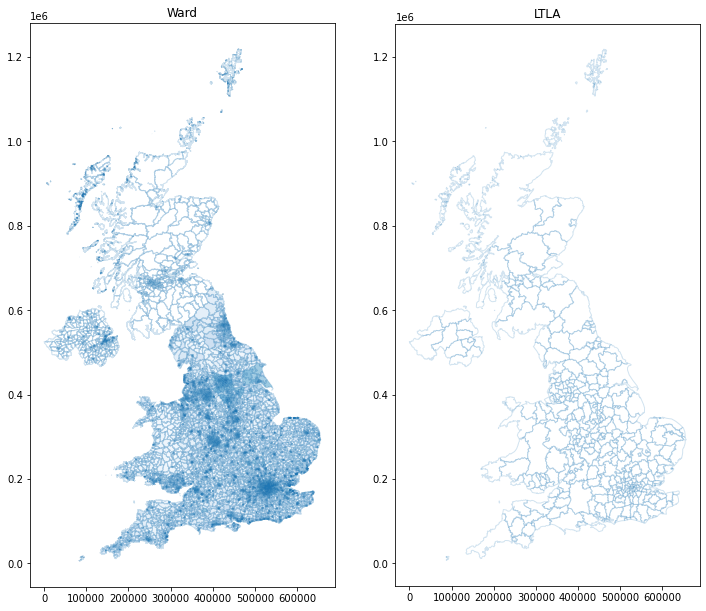

In [13]:
f, ax = plt.subplots(1, 2, figsize=(12, 12))
wd.plot(ax=ax[0], linewidth=1, alpha=1, column='All Ages', cmap='Blues')
wd.boundary.plot(ax=ax[0], linewidth=1, alpha=0.2)
ltla.boundary.plot(ax=ax[1], linewidth=1, alpha=0.2)
ax[0].set_title('Ward')
ax[1].set_title('LTLA')
plt.show()

# Get Covid Data from API

In [14]:
def get_data(url):
    print("Downloading data from URL " + url)
    response = get(url,timeout=60)
    if response.status_code >= 400:
        raise RuntimeError(f'Request failed: { response.text }')
    return response.text

In [15]:
data_string = get_data(api_url + '?' + urllib.parse.urlencode(params) + '&' + '&'.join(['metric=' + metrics[i] for i in range(len(metrics))]))
local_data = []
data_reader = csv.reader(StringIO(data_string), delimiter=',')
for line in data_reader:
    local_data.append(line)
covid = pd.DataFrame(local_data)
headers = covid.iloc[0]
covid = pd.DataFrame(covid.values[1:], columns=headers)
covid['date'] = pd.to_datetime(covid['date'])
covid = covid.rename(columns={'areaCode': 'LAD19CD'})
for metric in metrics:
    covid[metric] = pd.to_numeric(covid[metric], errors='ignore')

In [16]:
# Merge in LTLA data
ltla_covid = pd.merge(ltla, covid, on=['LAD19CD'], how='outer')

In [17]:
ltla_covid.head()

,OBJECTID,LAD19CD,LAD19NM,LAD19NMW,BNG_E,BNG_N,LONG,LAT,ST_AREASHA,ST_LENGTHS,geometry,date,areaType,areaName,newCasesBySpecimenDate,newDeaths28DaysByDeathDate
0,1,E06000001,Hartlepool,None,447160,531474,-1.27018,54.67614,9.684551e+07,50305.325058,"POLYGON ((448986.025 536729.674, 453194.600 53...",2021-02-01,ltla,Hartlepool,38.0,0.0
1,1,E06000001,Hartlepool,None,447160,531474,-1.27018,54.67614,9.684551e+07,50305.325058,"POLYGON ((448986.025 536729.674, 453194.600 53...",2021-01-31,ltla,Hartlepool,25.0,1.0
2,1,E06000001,Hartlepool,None,447160,531474,-1.27018,54.67614,9.684551e+07,50305.325058,"POLYGON ((448986.025 536729.674, 453194.600 53...",2021-01-30,ltla,Hartlepool,33.0,2.0
3,1,E06000001,Hartlepool,None,447160,531474,-1.27018,54.67614,9.684551e+07,50305.325058,"POLYGON ((448986.025 536729.674, 453194.600 53...",2021-01-29,ltla,Hartlepool,42.0,0.0
4,1,E06000001,Hartlepool,None,447160,531474,-1.27018,54.67614,9.684551e+07,50305.325058,"POLYGON ((448986.025 536729.674, 453194.600 53...",2021-01-28,ltla,Hartlepool,42.0,0.0


# Create plots

In [18]:
eng_ltla = ltla.loc[(ltla['LAD19CD'].str.startswith('E'))].copy()
wales_ltla = ltla.loc[(ltla['LAD19CD'].str.startswith('W'))].copy()
scot_ltla = ltla.loc[(ltla['LAD19CD'].str.startswith('S'))].copy()
df = ltla_covid.loc[(ltla_covid['date'] >= min_date) & (ltla_covid['date'] <= max_date) & ((ltla_covid['LAD19CD'].str.startswith('E')))]

In [19]:
dates = sorted(df['date'].unique())

In [20]:
norm = norm = plt.Normalize(vmin=0, vmax=5)
cmap = 'jet'
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

In [21]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'FLIPclockBlack'

In [ ]:
message_dates = [message['date'] for message in messages]
cases_xy = []
deaths_xy = []
total_cases = 0
total_deaths = 0
message = initial_message
message_alpha = 1.0
for i in range(len(dates))[0:max_days]:
    date = pd.Timestamp(dates[i])
    if date.year == 2021:
        day = 365 + date.dayofyear
    else:
        day = date.dayofyear
    if datetime.datetime(2020, 5, 10) > date >= datetime.datetime(2020, 3, 23):
        # Lockdown
        eng_ltla['status'] = 5
    elif datetime.datetime(2020, 11, 5) > date >= datetime.datetime(2020, 5, 10):
        # Tiers
        eng_ltla['status'] = 0
    elif datetime.datetime(2020, 12, 2) > date >= datetime.datetime(2020, 11, 5):
        # Lockdown
        eng_ltla['status'] = 5
    elif datetime.datetime(2020, 12, 28) > date >= datetime.datetime(2020, 12, 2):
        # Tiers
        eng_ltla['status'] = 0
    elif date >= datetime.datetime(2020, 12, 28):
        # Lockdown
        eng_ltla['status'] = 5
    else:
        eng_ltla['status'] = 0    
    cases = df.loc[(df['date'] == date)] 
    daily_cases_xy = []
    daily_deaths_xy = []
    for index, row in cases.iterrows():
        ward = wd.loc[(wd['LAD19CD'] == row['LAD19CD'])]
        g = ward['geometry']
        p = ward['All Ages'].values / np.sum(ward['All Ages'].values)
        if not math.isnan(row[cases_metric]):
            draw = choice(g, int(row[cases_metric]), p=p)
            for d in draw:
                xmin, ymin, xmax, ymax = d.bounds
                while True:
                    x = random.uniform(xmin, xmax)
                    y = random.uniform(ymin, ymax)
                    if Point(x, y).within(d):
                        daily_cases_xy.append([x,y])
                        break
        if not math.isnan(row[deaths_metric]):
            draw = choice(g, int(row[deaths_metric]), p=p)
            for d in draw:
                xmin, ymin, xmax, ymax = d.bounds
                while True:
                    x = random.uniform(xmin, xmax)
                    y = random.uniform(ymin, ymax)
                    if Point(x, y).within(d):
                        daily_deaths_xy.append([x,y])
                        break
    daily_cases_xy_split = np.array_split(np.array(daily_cases_xy), frames_per_day)
    daily_deaths_xy_split = np.array_split(np.array(daily_deaths_xy), frames_per_day)
    for j in range(frames_per_day):
        fig = plt.figure(figsize=(36, 36), frameon=True)
        ax = plt.gca()
        eng_ltla.boundary.plot(ax=ax, linewidth=1, alpha=0.5)
        wales_ltla.boundary.plot(ax=ax, linewidth=1, alpha=0.5)
        scot_ltla.boundary.plot(ax=ax, linewidth=1, alpha=0.5)
        eng_ltla.plot(ax=ax, linewidth=1, alpha=0.3, column='status', cmap=cmap, norm=norm, zorder=0)
        cases_xy.append(daily_cases_xy_split[j])
        deaths_xy.append(daily_deaths_xy_split[j])
        total_cases += len(daily_cases_xy_split[j])
        total_deaths += len(daily_deaths_xy_split[j])
        alpha_cases = 1.0
        alpha_deaths = 1.0
        for k in range(case_days):
            for l in range(frames_per_day):
                index = k*frames_per_day + l
                if total_cases < 10:
                    s = 256
                elif 10 < total_cases < 100:
                    s = 32
                else:
                    s = 16
                if len(cases_xy) > index and len(cases_xy[-index-1]) > 0 and alpha_cases > 0:
                    ax.scatter(cases_xy[-index-1][:, 0], cases_xy[-index-1][:, 1], s=s, color='g', alpha=alpha_cases, zorder=5)
                if total_deaths < 10:
                    s = 256
                elif 10 < total_deaths < 100:
                    s = 128
                else:
                    s = 64
                if len(deaths_xy) > index and len(deaths_xy[-index-1]) > 0 and alpha_deaths > 0:
                    ax.scatter(deaths_xy[-index-1][:, 0], deaths_xy[-index-1][:, 1], s=s, color='r', alpha=alpha_deaths, zorder=10)
            alpha_cases -= 1 / case_days 
            alpha_deaths -= 0.5
        ax.axis(margins)
        ax.set_aspect('equal')
        plt.axis('off')
        c_str = "%d" % total_cases
        #while len(c_str) < (c_size + 2): c_str = "-" + c_str
        d_str = "%d" % total_deaths
        #while len(d_str) < (c_size): d_str = "-" + d_str
        plt.text(x_text, y_date, datetime.datetime.strftime(date,"%b %d"), horizontalalignment='right', fontsize=date_size)
        plt.text(x_text, y_cases + 30000, 'CASES', horizontalalignment='right', fontsize=50)
        plt.text(x_text, y_cases, c_str, horizontalalignment='right', fontsize=counter_size)
        plt.text(x_text, y_deaths + 30000, 'DEATHS', horizontalalignment='right', fontsize=50)
        plt.text(x_text, y_deaths, d_str, horizontalalignment='right', fontsize=counter_size) 
        if plot_messages:
            if date in message_dates:
                message = messages[message_dates.index(date)]['message']
                message_alpha = 1.0
            else:
                message_alpha -= 1 / (20 * frames_per_day)
            if message_alpha > 0:
                plt.text(x_text, 640000, message, fontsize=50, alpha=message_alpha, horizontalalignment='right')
        if plot_author:
            plt.text(x_text, 30000, '@adamjmoss80', fontsize=50, horizontalalignment='right')
        if plot_legend:
            circle = plt.Circle((margins[0] + 5000, 455000), 5000, color='g')
            ax.add_patch(circle)
            plt.text(margins[0] + 20000, 452500, 'Active cases (7 days from positive test)', fontsize=30)
            circle = plt.Circle((margins[0] + 5000, 425000), 5000, color='r')
            ax.add_patch(circle)
            plt.text(margins[0] + 20000, 422500, 'Deaths by registration date', fontsize=30)
        plt.tight_layout()
        plt.savefig(output_directory + '/%s' % (frames_per_day*day + j), bbox_inches='tight')
        plt.close()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
